# TCC 2 - Yan Borges 

## Importando bibliotecas 

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import math
import random 
import config
import matplotlib.pyplot as plt

#Bibliotecas para a leitura dos dados
from scipy.io.arff import loadarff

#Bibliotecas para a análise de dados
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import RegressorChain
from sklearn.cluster import KMeans
import xgboost as xgb

#Bibliotecas para a avaliação dos modelos
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer

#Bibliotecas para a validação cruzada
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#Bibliotecas para a análise de agrupamento
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

## Funções

### Modelos

In [2]:
def model_xgboost():
    param = {'max_depth': 4,
             'eta': 0.05, 
             'objective': 'reg:squarederror',
             'booster': 'gbtree',
            }
    bst = xgb.XGBRegressor(**param, n_estimators=100)
    return bst

def model_xgboost_multi():
    param = {'max_depth': 4,
             'eta': 0.05, 
             'objective': 'reg:squarederror',
             'booster': 'gbtree',
            }
    bst = xgb.XGBRegressor(**param, n_estimators=100, tree_method='hist', multi_strategy='multi_output_tree')
    return bst

def Chain_RandomForest():
    reg_chain = RegressorChain(RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state=0))
    return reg_chain

def Chain_DecisionTree():
    reg_chain = RegressorChain(DecisionTreeRegressor())
    return reg_chain

def model_randomForest():
    regressor = RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state=0)
    return regressor

def model_dtree():
    regressor = DecisionTreeRegressor()
    return regressor

def model_multi_dtree():
    regressor = MultiOutputRegressor(DecisionTreeRegressor())
    return regressor

def model_multi_randomForest():
    regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state=0))
    return regressor


### Cálculo de erro 

In [3]:
def computer_RRMSE_list(real_test,result_p,real_target_mean):
    """RRMSE: Relative Root Mean Square Error
        input: real_test: real test data
              result_p: predicted data
              real_target_mean: mean of real train data
        output: RRMSE list """
    
    _list = []

    if result_p[1].shape == ():
        numerador = 0
        denominador = 0
        for j in range(result_p.shape[0]):
            numerador += (result_p[j] - real_test[j])**2
            denominador += (real_target_mean - real_test[j])**2
        _list.append(math.sqrt(numerador/denominador))    
        return _list
    else:
        for i in range(result_p.shape[1]):
            numerador = 0
            denominador = 0
            for j in range(result_p.shape[0]):
                numerador += (result_p[j,i] - real_test[j,i])**2
                denominador += (real_target_mean[i] - real_test[j,i])**2
            _list.append(math.sqrt(numerador/denominador))    
        return _list    

def calculate_RRMSE(targets, predicted):
    targets_mean = np.mean(targets, axis=0)
    loss_list_RRMSE = computer_RRMSE_list(targets, predicted, targets_mean)
    mean_error = np.array(loss_list_RRMSE).mean(axis=0)
    return mean_error

## Implementação

In [8]:
path = "../TCC/mtr-datasets/"

#text_file = input("dataset: ")
text_file = 'andro'
data, meta = loadarff(path + text_file + ".arff")
data = pd.DataFrame(data)

data.reset_index(inplace=True)
data.replace('?', np.nan, inplace=True)
data.replace('     ?', np.nan, inplace=True)
data = data.applymap(float)

#Caso de Exceção por ter coluna com muito Null
if text_file == 'osales':
    conta_na = data.isna().sum()
    conta_na[conta_na > 70].index
    data.drop(columns=conta_na[conta_na > 70].index, inplace=True)

#Normalização
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

if config.all_config[text_file].get('sample_random') == True:
    data = data.sample(frac=1,random_state = config.all_config[text_file].get('sample_random_num')).reset_index(drop=True)
data = data.fillna(pd.Series(np.nanmean(data,axis=0),index=data.columns))
label = data.iloc[:,-config.all_config[text_file].get('targets_num'):].values
data = data.iloc[:,:-config.all_config[text_file].get('targets_num')].values

#Lista para comparar resultados de teste no final
error_results = []

print('Base', text_file)
print('Shape', data.shape) 
print('Targets', label.shape)

Base andro
Shape (49, 31)
Targets (49, 6)


### Separação dos dados em Treino e Teste 


In [9]:
# Não estou usando mais 
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
 
label_mean = label.mean(axis=0)

RRMSE_scorer = make_scorer(calculate_RRMSE, greater_is_better=False)

if  text_file == 'rf1' or text_file == 'rf2' or text_file == 'scm1d' or text_file == 'scm20d':
    kfold = KFold(n_splits=2, shuffle=True, random_state=42)
else:
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)


## Modelos Tradicionais

#### Random Forest e Decision Tree com cross validate 

In [16]:
score = cross_validate(model_randomForest(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print(score)
error_results.append(('RF',score))

0.845525914222384


In [17]:
score = cross_validate(model_dtree(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print(score)
error_results.append(('DT',score))

0.9727132024613784


#### Decision Tree Local 

In [20]:
scores = np.zeros(label.shape[1])

for target in range(label.shape[1]):
    y = label[:,[target]].ravel()

    score = cross_validate(DecisionTreeRegressor(), data, y, cv=kfold, scoring=RRMSE_scorer)

    scores[target] = np.sqrt(-score['test_score']).mean()

print("Mean Score: ", scores.mean())

Mean Score:  0.9296647865246012


#### Regressor Chain Padrão RF

In [21]:
score = cross_validate(Chain_RandomForest(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("Regressor chain of Random Forest: ", score)
error_results.append(('Chain of RF',score))

Regressor chain of Random Forest:  0.8505639708954498


#### Regressor Chain Padrão DT

In [22]:
score = cross_validate(Chain_DecisionTree(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("Regressor chain of Random Forest: ", score)
error_results.append(('Chain of DT',score))

Regressor chain of Random Forest:  0.9532570319748415


#### Multi Output Decision Tree

In [23]:
score = cross_validate(model_multi_dtree(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("MultiOutput Regressor DT: ", score)
error_results.append(('MultiOutput DT',score))

MultiOutput Regressor DT:  0.9659527463152479


#### Multi Output Random Forest

In [24]:
score = cross_validate(model_multi_randomForest(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("MultiOutput Regressor RF: ", score)
error_results.append(('MultiOutput RF',score))

MultiOutput Regressor RF:  0.8355304289203251


#### Xgboost

Local

In [25]:
score = cross_validate(model_xgboost(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("XGBoost: ",score)
error_results.append(('XGBoost',score))

XGBoost:  0.8351173775227807


Multi

In [26]:
score = cross_validate(model_xgboost_multi(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("XGBoost: ",score)
error_results.append(('XGBoost Multi',score))

XGBoost:  0.8555800030383995


## Método de Clusterização

### Matriz de Dissimilaridade 

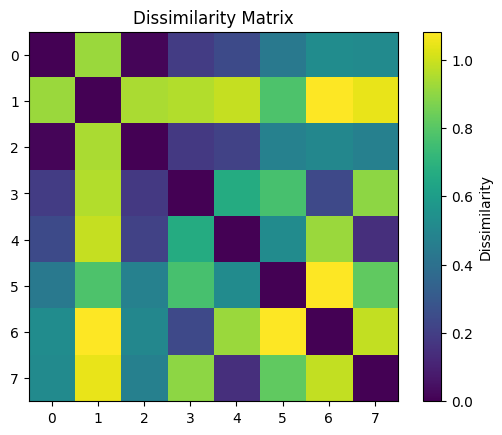

In [50]:
matriz_dissimilaridade = 1 - np.corrcoef(y_train.T)

plt.imshow(matriz_dissimilaridade, cmap='viridis')
plt.colorbar(label='Dissimilarity')
plt.title('Dissimilarity Matrix')
plt.show()

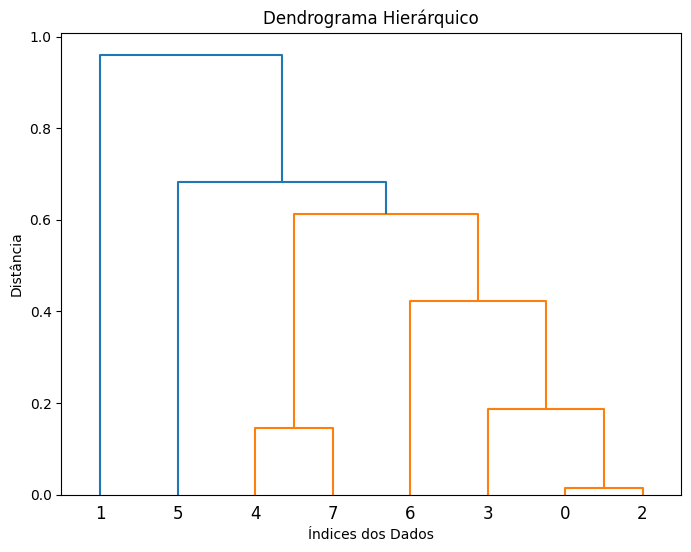

In [51]:
#Garante que a diagonal principal é zero
np.fill_diagonal(matriz_dissimilaridade, 0)

# Garante que a matriz de dissimilaridade seja simétrica
matriz_dissimilaridade = (matriz_dissimilaridade + matriz_dissimilaridade.T) / 2

# Converte a matriz de dissimilaridade quadrada para a forma condensada
matriz_dissim_cond = squareform(matriz_dissimilaridade)

linkage_matrix = linkage(matriz_dissim_cond, method='average')

plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Índices dos Dados')
plt.ylabel('Distância')
plt.show()

Precisa tratar o caso de erro de o ideal ser apenas um cluster

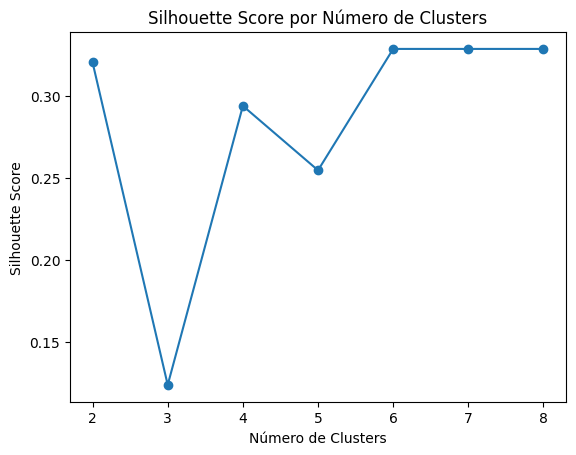

In [52]:
silhouette_scores = []

min_clusters = 2
if label.shape[1] < 10:
    max_clusters = label.shape[1]+1
else:
    max_clusters = 10

for n_clusters in range(min_clusters, max_clusters):
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    silhouette_scores.append(silhouette_score(matriz_dissimilaridade, cluster_labels))
    #Apenas para visualização, nao serve para nada no código
    # print(f'Número de clusters: {n_clusters}')
    # print(cluster_labels)

plt.plot(range(min_clusters, max_clusters), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.show()

In [53]:
best_cut = silhouette_scores.index(max(silhouette_scores)) + min_clusters
print('Best number of clusters:', best_cut)

clusters = fcluster(linkage_matrix, best_cut, criterion='maxclust')

label_cluster = [[] for _ in range(max(clusters))]

# Split the targets into clusters
for i, cluster in enumerate(clusters):
    label_cluster[cluster-1].append(label[:, i])
    # print('Cluster: {}, Target: {}'.format(cluster-1, i))

label_cluster = [np.array(cluster).T for cluster in label_cluster]

# print the number of targets in each cluster
for i, cluster in enumerate(label_cluster):
    print('Cluster: {}, Number of targets: {}'.format(i, cluster.shape[1]))

Best number of clusters: 6
Cluster: 0, Number of targets: 2
Cluster: 1, Number of targets: 2
Cluster: 2, Number of targets: 1
Cluster: 3, Number of targets: 1
Cluster: 4, Number of targets: 1
Cluster: 5, Number of targets: 1


### Regressor Chain de Random Forest Clusterizado

In [ ]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    score = cross_validate(Chain_RandomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Regressor chain of Random Forest Clusterizado: ", error)
error_results.append(('Clusterizado Chain of RF',error))

Regressor chain of Random Forest Clusterizado:  0.736441936103712


### Regressor Chain de Decision Tree Clusterizado

In [ ]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    score = cross_validate(Chain_DecisionTree(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Regressor chain of Decision Tree Clusterizado: ", error)
error_results.append(('Clusterizado Chain of DT',error))

Regressor chain of Decision Tree Clusterizado:  0.8539995466549597


### Random forest Clusterizado

In [ ]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    if y.shape[1] == 1:
        y = y.ravel()
    score = cross_validate(model_randomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Random Forest Clusterizado: ", error)
error_results.append(('Clusterizado RF',error))

Random Forest Clusterizado:  0.7519407559319299


### Decision Tree Clusterizado

In [ ]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    if y.shape[1] == 1:
        y = y.ravel()
    score = cross_validate(model_dtree(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("Decision Tree Clusterizado: ", error)
error_results.append(('Clusterizado DT',error))

Decision Tree Clusterizado:  0.8290807902592826


### XGBoost Clusterizado

Não faz sentido utilizar esse regressor em clusterizado se ele utiliza uma abordagem local

In [ ]:
# errors = []

# for i in range(len(label_cluster)):
#     y = label_cluster[i]
#     if y.shape[1] == 1:
#         y = y.ravel()
#     score = cross_validate(model_xgboost(), data, y, cv=kfold, scoring=RRMSE_scorer)
#     score = np.sqrt(-score['test_score']).mean()
#     errors.append(score)
#     # print(score)

# error = np.mean(errors)
# print("XGBoost Clusterizado: ", error)
# error_results.append(('Clusterizado XGBoost',error))

In [ ]:
errors = []

for i in range(len(label_cluster)):
    y = label_cluster[i]
    if y.shape[1] == 1:
        y = y.ravel()
    score = cross_validate(model_xgboost_multi(), data, y, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

error = np.mean(errors)
print("XGBoost Clusterizado Multi: ", error)
error_results.append(('Clusterizado XGBoost Multi',error))

XGBoost Clusterizado Multi:  0.76918749067141


## Método de Clusterização Randômica 

Antigo: pois agora itero 10 vezes para ter um resultado melhor 

In [ ]:
# ITER = 10

# max_clusters = np.random.randint(2, label.shape[1])

# label_cluster_random = [[] for _ in range(max_clusters)]

# lista = list(range(label.shape[1]))

# # Passo 1: Distribua pelo menos um elemento para cada cluster
# for cluster in range(max_clusters):
#     element = lista.pop(np.random.randint(0, len(lista)))
#     label_cluster_random[cluster-1].append(label[:, element])
#     # print('Initial Cluster: {}, Target: {}'.format(cluster, element))

# # Passo 2: Distribua os elementos restantes de forma aleatória
# while lista:
#     cluster = np.random.randint(0, max_clusters)
#     element = lista.pop(0)
#     label_cluster_random[cluster-1].append(label[:, element])
#     # print('Random Cluster: {}, Target: {}'.format(cluster, element))

# # print()

# for i in range(len(label_cluster_random)):
#     print(np.array(label_cluster_random[i]).T.shape)

In [ ]:

#VERIFICAÇÃO FEITA DEVIDA A TAMANHO DA BASE
if  text_file == 'rf1' or text_file == 'rf2' or text_file == 'scm1d' or text_file == 'scm20d':
    ITER = 5
else:
    ITER = 10

# Inicializa a lista para armazenar os resultados de cada iteração
clusters_rand = []

for _ in range(ITER):
    n_clusters = np.random.randint(2, label.shape[1])
    target_cluster_random = [[] for _ in range(n_clusters)]
    targets = list(range(label.shape[1]))
    random.shuffle(targets)

    # Passo 1: Distribua pelo menos um elemento para cada cluster
    for cluster in range(n_clusters):
        target = targets.pop(0)
        target_cluster_random[cluster-1].append(label[:, target])

    # Passo 2: Distribua os targets restantes de forma aleatória
    while targets:
        cluster = np.random.randint(0, n_clusters)
        target = targets.pop(0)
        target_cluster_random[cluster-1].append(label[:, target])

    # Converte cada cluster em um array numpy e adiciona na lista de resultados
    clusters_array = [np.array(cluster).T for cluster in target_cluster_random]
    clusters_rand.append(clusters_array)


# Exibindo as formas de cada iteração para verificação
for i in range(len(clusters_rand)):
    print(f'Iteração {i+1}:')
    for j in range(len(clusters_rand[i])):
        print(f'  Cluster {j+1}: {clusters_rand[i][j].shape}')


Iteração 1:
  Cluster 1: (334, 4)
  Cluster 2: (334, 2)
  Cluster 3: (334, 1)
  Cluster 4: (334, 2)
  Cluster 5: (334, 2)
  Cluster 6: (334, 3)
  Cluster 7: (334, 2)
Iteração 2:
  Cluster 1: (334, 2)
  Cluster 2: (334, 1)
  Cluster 3: (334, 3)
  Cluster 4: (334, 1)
  Cluster 5: (334, 1)
  Cluster 6: (334, 1)
  Cluster 7: (334, 1)
  Cluster 8: (334, 2)
  Cluster 9: (334, 1)
  Cluster 10: (334, 1)
  Cluster 11: (334, 2)
Iteração 3:
  Cluster 1: (334, 3)
  Cluster 2: (334, 2)
  Cluster 3: (334, 4)
  Cluster 4: (334, 1)
  Cluster 5: (334, 1)
  Cluster 6: (334, 1)
  Cluster 7: (334, 1)
  Cluster 8: (334, 1)
  Cluster 9: (334, 2)
Iteração 4:
  Cluster 1: (334, 4)
  Cluster 2: (334, 4)
  Cluster 3: (334, 2)
  Cluster 4: (334, 6)
Iteração 5:
  Cluster 1: (334, 3)
  Cluster 2: (334, 1)
  Cluster 3: (334, 3)
  Cluster 4: (334, 1)
  Cluster 5: (334, 1)
  Cluster 6: (334, 3)
  Cluster 7: (334, 4)
Iteração 6:
  Cluster 1: (334, 2)
  Cluster 2: (334, 2)
  Cluster 3: (334, 1)
  Cluster 4: (334, 1)
  

In [ ]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_randomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Random Forest Clusterizado Random: ", error)
error_results.append(('Random Cluster - RF',error))

Random Forest Clusterizado Random:  0.6942202819237183


In [ ]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_dtree(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Decision Tree Clusterizado: ", np.mean(errors))
error_results.append(('Random Cluster - DT',error))

Decision Tree Clusterizado:  0.8204930365635938


In [ ]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        score = cross_validate(Chain_RandomForest(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Regressor chain of Random Forest Clusterizado Random: ", error)
error_results.append(('Random Cluster - Chain of RF',error))

Regressor chain of Random Forest Clusterizado Random:  0.6862604326126208


In [ ]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        score = cross_validate(Chain_DecisionTree(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("Regressor chain of Decision Tree Clusterizado Random: ", error)
error_results.append(('Random Cluster - Chain of DT',error))

Regressor chain of Decision Tree Clusterizado Random:  0.8093219749570315


Não faz sentido utilizar esse regressor se ele faz uso de uma abordagem local

In [ ]:
# errors = []

# for i in range(len(clusters_rand)):
#     for j in range(len(clusters_rand[i])):
#         y = clusters_rand[i][j]
#         if y.shape[1] == 1:
#             y = y.ravel()
#         score = cross_validate(model_xgboost(), data, y, cv=kfold, scoring=RRMSE_scorer)
#         score = np.sqrt(-score['test_score']).mean()
#         errors.append(score)
#         # print(score)

# error = np.mean(errors)
# print("XGBoost Clusterizado Randômico: ", np.mean(errors))
# error_results.append(('Random Cluster - XGBoost',error))

In [ ]:
errors = []

for i in range(len(clusters_rand)):
    for j in range(len(clusters_rand[i])):
        y = clusters_rand[i][j]
        if y.shape[1] == 1:
            y = y.ravel()
        score = cross_validate(model_xgboost_multi(), data, y, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors.append(score)
        # print(score)

error = np.mean(errors)
print("XGBoost Multi Clusterizado Randômico: ", np.mean(errors))
error_results.append(('Random Cluster - XGBoost Multi',error))

XGBoost Multi Clusterizado Randômico:  0.7318009353433712


## Resultados 

In [ ]:
error_results = pd.DataFrame(error_results, columns=['Model', 'RRMSE'])
error_results

,Model,RRMSE
0,RF,0.715017
1,DT,0.878688
2,Chain of RF,0.691526
3,Chain of DT,0.817058
4,MultiOutput DT,0.831791
5,MultiOutput RF,0.690909
6,XGBoost,0.734127
7,XGBoost Multi,0.773786
8,Clusterizado Chain of RF,0.736442
9,Clusterizado Chain of DT,0.854000


In [ ]:
#ordena os resultados por erro crescente
error_results = error_results.sort_values(by='RRMSE', ascending=True)
error_results

,Model,RRMSE
15,Random Cluster - Chain of RF,0.686260
5,MultiOutput RF,0.690909
2,Chain of RF,0.691526
13,Random Cluster - RF,0.694220
0,RF,0.715017
17,Random Cluster - XGBoost Multi,0.731801
6,XGBoost,0.734127
8,Clusterizado Chain of RF,0.736442
10,Clusterizado RF,0.751941
12,Clusterizado XGBoost Multi,0.769187


In [ ]:
#ordena os resultados por nome do modelo crescente
error_results = error_results.sort_values(by='Model', ascending=True)
error_results

,Model,RRMSE
3,Chain of DT,0.817058
2,Chain of RF,0.691526
9,Clusterizado Chain of DT,0.854000
8,Clusterizado Chain of RF,0.736442
11,Clusterizado DT,0.829081
10,Clusterizado RF,0.751941
12,Clusterizado XGBoost Multi,0.769187
1,DT,0.878688
4,MultiOutput DT,0.831791
5,MultiOutput RF,0.690909
